In [1]:
import time
import unittest
from test.test_crop import Test_saturation_vapor_pressure_slope

import cupy as cp
import dask
import numpy as np
import pandas as pd
import dask.array as da
import src.geocat.comp.crop as geo
import xarray as xr
csvpath = "saturation_vapor_pressure_slope_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 15})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_saturation_vapor_pressure_slope"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)

def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Cluster

### CPU cluster on PBS cluster

In [3]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCPU = PBSCluster(memory='100 GB',
                     processes=3,
                     cores=3,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=3:mem=100gb')
print(clusterCPU.job_script())
clusterCPU.scale(1)
client = Client(clusterCPU)
#cluster.close()


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=3:mem=100gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:35478 --nthreads 1 --nprocs 3 --memory-limit 31.04GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36570 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/36570/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/36570/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:35478,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/36570/status,Total threads: 0
Started: Just now,Total memory: 0 B


### CUDA cluster on PBS cluster

In [5]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCUDA = PBSCluster(memory='200 GB',
                     processes=1,
                     cores=1,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=1:ngpus=1:mem=200gb')
print(clusterCUDA.job_script())
clusterCUDA.scale(1)
client = Client(clusterCUDA)
#cluster.close()

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43706 instead
  warnings.warn(


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:ngpus=1:mem=200gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:33207 --nthreads 1 --memory-limit 186.26GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/43706/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/43706/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:33207,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/43706/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Initializing Arrays

In [7]:
max_power = 8
chunksize = 10**5
temp_arrays = []
for i in range(1,max_power):
    temp_arrays.append(xr.DataArray(np.arange(1, 10**i+1, 1)))
numpy_results = []
cupy_results = []

## Testing Numpy input and CPU

In [8]:
xp = np
for i in range(max_power-1):
    temp = temp_arrays[i].data
    ncl_gt1 = geo.saturation_vapor_pressure_slope(temp, use_gpu = False)

In [9]:
type(ncl_gt1)

numpy.ndarray

## Testing Numpy input and GPU

In [10]:
for i in range(max_power-1):
    temp = temp_arrays[i].data
    ncl_gt2 = geo.saturation_vapor_pressure_slope(temp, use_gpu = True)

In [11]:
type(ncl_gt2)

cupy._core.core.ndarray

# this function is not ported for xarray and dask since cp.exp doesn't recognize dask and xarray

## Testing Xarray input and CPU

In [12]:
from src.geocat.comp.comp_util import _is_duck_array, _convert_to_gpu_array

In [13]:
for i in range(max_power-1):
    temp = temp_arrays[i]
    ncl_gt1 = geo.saturation_vapor_pressure_slope(temp, use_gpu = False)

In [14]:
type(ncl_gt1.data)

numpy.ndarray

## Testing Xarray input and GPU

In [15]:
for i in range(max_power-1):
    temp = temp_arrays[i]
    ncl_gt2 = geo.saturation_vapor_pressure_slope(temp, use_gpu = True)

In [16]:
type(ncl_gt2.data)

numpy.ndarray

## Testing Dask input with CPU

In [17]:
client = Client(clusterCPU)
for i in range(2):
    temp = temp_arrays[i].chunk(10)
    ncl_gt1 = geo.saturation_vapor_pressure_slope(temp, use_gpu = False).compute()

In [18]:
ncl_gt1

<xarray.DataArray (dim_0: 100)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.04604162, 0.04770467, 0.04941909,
       0.05118619, 0.05300728, 0.05488373, 0.05681688, 0.05880815,
       0.06085895, 0.06297073, 0.06514496, 0.06738315, 0.06968681,
       0.0720575 , 0.07449681, 0.07700634, 0.07958771, 0.08224261,
       0.0849727 , 0.08777973, 0.09066542, 0.09363156, 0.09667996,
       0.09981244, 0.10303087, 0.10633715, 0.10973319, 0.11322096,
       0.11680242, 0.12047961, 0.12425456, 0.12812935, 0.13210609,
       0.13618692, 0.140374  , 0.14466955, 0.14907579, 0.153595  ,
       0.15822946, 0.16298153, 0.16785355, 0.17284794, 0.17796712,
       0.18321355, 0.18858974, 0.19409822, 0.19974156, 0.20552235,
       0.21144324, 0.21750689, 0.22371602, 0.23007335, 0.23658166,
       0.24324377, 0.25006252, 0.25704078, 0.26418149, 0.27148759,
       0.27896206, 0.28660794, 0.29442828, 0.30242618, 0.31060478,
       0.31896724, 0.32751677, 0.33625661, 0.34519005, 0.35432041])
Dimensions without coordinates: dim_0
Attributes:
    long_name:  slope saturation vapor pressure curve
    units:      kPa/C
    url:        https://www.fao.org/docrep/X0490E/x0490e07.htm
    info:       FAO 56; EQN 13; saturation_vapor_pressure_slope

## Testing Dask input with GPU

In [19]:
#client = Client(clusterCUDA)
for i in range(2):
    temp = temp_arrays[i].chunk(10)
    ncl_gt2 = geo.saturation_vapor_pressure_slope(temp, use_gpu = True).compute()

In [20]:
ncl_gt2

<xarray.DataArray (dim_0: 100)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.04604162, 0.04770467, 0.04941909,
       0.05118619, 0.05300728, 0.05488373, 0.05681688, 0.05880815,
       0.06085895, 0.06297073, 0.06514496, 0.06738315, 0.06968681,
       0.0720575 , 0.07449681, 0.07700634, 0.07958771, 0.08224261,
       0.0849727 , 0.08777973, 0.09066542, 0.09363156, 0.09667996,
       0.09981244, 0.10303087, 0.10633715, 0.10973319, 0.11322096,
       0.11680242, 0.12047961, 0.12425456, 0.12812935, 0.13210609,
       0.13618692, 0.140374  , 0.14466955, 0.14907579, 0.153595  ,
       0.15822946, 0.16298153, 0.16785355, 0.17284794, 0.17796712,
       0.18321355, 0.18858974, 0.19409822, 0.19974156, 0.20552235,
       0.21144324, 0.21750689, 0.22371602, 0.23007335, 0.23658166,
       0.24324377, 0.25006252, 0.25704078, 0.26418149, 0.27148759,
       0.27896206, 0.28660794, 0.29442828, 0.30242618, 0.31060478,
       0.31896724, 0.32751677, 0.33625661, 0.34519005, 0.35432041])
Dimensions without coordinates: dim_0
Attributes:
    long_name:  slope saturation vapor pressure curve
    units:      kPa/C
    url:        https://www.fao.org/docrep/X0490E/x0490e07.htm
    info:       FAO 56; EQN 13; saturation_vapor_pressure_slope

## Unittests with CPU!

In [21]:
client = Client(clusterCPU)
test = Test_saturation_vapor_pressure_slope()

test.setUpClass()
test.test_float_input(use_gpu = False)
test.test_list_input(use_gpu = False)
test.test_numpy_input(use_gpu = False)
test.test_multi_dimensional_input(use_gpu = False)
test.test_xarray_input(use_gpu = False)
test.test_dask_compute(use_gpu = False)
test.test_dask_lazy(use_gpu = False)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38049 instead
  warnings.warn(
2022-07-15 09:08:14,400 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-zpdc1flu', purging


## Unittests with GPU

In [22]:
client = Client(clusterCUDA)
test = Test_saturation_vapor_pressure_slope()

test.setUpClass()
test.test_float_input(use_gpu = True)
test.test_list_input(use_gpu = True)
test.test_numpy_input(use_gpu = True)
test.test_multi_dimensional_input(use_gpu = True)
test.test_xarray_input(use_gpu = True)
test.test_dask_compute(use_gpu = True)
test.test_dask_lazy(use_gpu = True)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45916 instead
  warnings.warn(


## Benchmark Results for different Array Sizes (NUMPY/CUPY)

saturation_vapor_pressure_slope
Array size:  100
numpy 2.255439758300781e-05 seconds
cupy 0.0021821737289428713 seconds
Array size:  1000
numpy 3.237724304199219e-05 seconds
cupy 0.00043256282806396483 seconds
Array size:  10000
numpy 0.00010080337524414063 seconds
cupy 0.0005521774291992188 seconds
Array size:  100000
numpy 0.0025871992111206055 seconds
cupy 0.0006269931793212891 seconds
Array size:  1000000
numpy 0.024953007698059082 seconds
cupy 0.0040490150451660155 seconds
Array size:  10000000
numpy 0.4071833848953247 seconds
cupy 0.03370556831359863 seconds


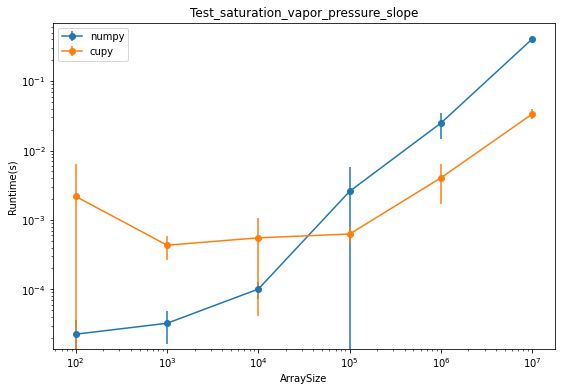

In [23]:
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(2,max_power):
    ArraySize = 10**i
    temp = temp_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.saturation_vapor_pressure_slope(temp,use_gpu=True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.saturation_vapor_pressure_slope(temp,use_gpu=True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                time1 = time.time()
                res_numpy = geo.saturation_vapor_pressure_slope(temp,use_gpu=False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    #test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_saturation_vapor_pressure_slope_ported_numpy.jpg")

In [24]:
type(res_cupy)

cupy._core.core.ndarray

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test saturation_vapor_pressure_slope on CPU

In [25]:
client = Client(clusterCPU)
client

<Client: 'tcp://10.12.205.44:35478' processes=3 threads=3, memory=93.12 GiB>

In [26]:
csvpath = "saturation_vapor_pressure_slope_ported_test_xarray.csv"
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    pressure = pressure_arrays[i-1].data
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure_slope(pressure , False)
        time1 = time.time()
        numpy_res = geo.saturation_vapor_pressure_slope(pressure , False)
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

saturation_vapor_pressure_slope
Array size:  10


NameError: name 'pressure_arrays' is not defined

### Test saturation_vapor_pressure_slope on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    pressure = pressure_arrays[i-1]
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure_slope(pressure, True)
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.saturation_vapor_pressure_slope(pressure, True)
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_saturation_vapor_pressure_slope_ported_xarray.jpg")

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
cupy_results[0]

In [ ]:
numpy_results[0]

## Benchmark Results for different ArraySizes Xarray (with Dask arrays inside the Xarray, then dask array type is either NumPy or CuPy)

### Test saturation_vapor_pressure_slope on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "saturation_vapor_pressure_slope_ported_test_dask.csv"
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def, False).compute()
        time1 = time.time()
        numpy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def, False).compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test saturation_vapor_pressure_slope on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

plot(allData,"Test_saturation_vapor_pressure_slope_ported_dask.jpg")

In [ ]:
cupy_res.data

In [ ]:
numpy_res.data

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
numpy_results[0]

In [ ]:
cupy_results[0]

In [ ]:
len(numpy_results)

### Only comparing "compute()" runtime

In [ ]:
chunksize = 10**5

#### on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "saturation_vapor_pressure_slope_ported_test_dask_compute_10.csv"
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def,False)
        numpy_res.compute()
        time1 = time.time()
        numpy_res = numpy_res.compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

#### on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure_slope main body
Routine = "saturation_vapor_pressure_slope"
print(Routine)
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure_slope(tk_def, rh_def,True)
        cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

In [ ]:
plot(allData,"Test_saturation_vapor_pressure_slope_ported_compute")

#### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)